In [31]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [32]:
from dataset import NASBench101Dataset

### Load dataset

In [33]:
train_size = "2000" # TODO change to 172
dataset = NASBench101Dataset('data/nasbench101.hdf5', train_size) 
dataset_all = NASBench101Dataset('data/nasbench101.hdf5', "all")

### Feature extraction

In [34]:
from utils import get_targets, get_flat_features, get_flat_features_boosted, get_gcn_features 

In [35]:
# Get train data features and targets
predictor_build_features = get_flat_features(dataset)
predictor_build_targets = get_targets(dataset)

# Get extended train data features (additional features) 
predictor_build_features_ext = get_flat_features_boosted(dataset)

# Get data for applying predictors
all_features = get_flat_features(dataset_all)
all_targets = get_targets(dataset_all)

In [61]:
from sklearn.model_selection import train_test_split

# Divide features into train and test sets
train_features, train_targets, test_features, test_targets = train_test_split(
    predictor_build_features, predictor_build_targets, test_size=0.2, random_state=42
)

In [36]:
features_100k = all_features[:100000]
targets_100k = all_targets[:100000]

In [37]:
print(train_features.shape)
print(train_features_ext.shape)

(2000, 84)
(2000, 86)


## Training the predictors

### Linear regression predictor

- [] add hyperparams

In [38]:
from predictors.linear_regression import LRPredictor


lr_predictor = LRPredictor()

# Measure time
start = time.time()
# Fit predictor
lr_predictor.fit(train_features, train_targets)
print("Training time ("+train_size+f" samples): {time.time() - start:.2f}s")

Training time (2000 samples): 0.02s


### Random forest predictor
- [] add hyperparams

In [39]:
from predictors.random_forest import RFPredictor


rf_predictor = RFPredictor()

# Measure time
start = time.time()
# Fit predictor
rf_predictor.fit(train_features, train_targets)
print("Training time ("+train_size+f" samples): {time.time() - start:.2f}s")

Training time (2000 samples): 0.45s


### XGBoost predictor
- [] add hyperparams

In [40]:
from predictors.xgb import XGBPredictor


xgb_predictor = XGBPredictor()

# Measure time
start = time.time()
# Fit predictor
xgb_predictor.fit(train_features, train_targets)
print("Training time ("+train_size+f" samples): {time.time() - start:.2f}s")

Training time (2000 samples): 0.30s


### MLP predictor
- [] add hyperparams

In [41]:
from predictors.mlp import MLPPredictor


mlp_predictor = MLPPredictor()

# Measure time
start = time.time()
# Fit predictor
mlp_predictor.fit(train_features, train_targets)
print("Training time ("+train_size+f" samples): {time.time() - start:.2f}s")

[05/13 14:33:08] INFO (root) Epoch 1/500, Loss: 1.9485
[05/13 14:33:09] INFO (root) Epoch 2/500, Loss: 1.7170
[05/13 14:33:09] INFO (root) Epoch 3/500, Loss: 1.2253
[05/13 14:33:10] INFO (root) Epoch 4/500, Loss: 0.8951
[05/13 14:33:10] INFO (root) Epoch 5/500, Loss: 0.7602
[05/13 14:33:11] INFO (root) Epoch 6/500, Loss: 0.6517
[05/13 14:33:11] INFO (root) Epoch 7/500, Loss: 0.5848
[05/13 14:33:12] INFO (root) Epoch 8/500, Loss: 0.5121
[05/13 14:33:12] INFO (root) Epoch 9/500, Loss: 0.4629
[05/13 14:33:12] INFO (root) Epoch 10/500, Loss: 0.4437
[05/13 14:33:13] INFO (root) Epoch 11/500, Loss: 0.4169
[05/13 14:33:13] INFO (root) Epoch 12/500, Loss: 0.4035
[05/13 14:33:14] INFO (root) Epoch 13/500, Loss: 0.3891
[05/13 14:33:14] INFO (root) Epoch 14/500, Loss: 0.3306
[05/13 14:33:15] INFO (root) Epoch 15/500, Loss: 0.3339
[05/13 14:33:15] INFO (root) Epoch 16/500, Loss: 0.3318
[05/13 14:33:16] INFO (root) Epoch 17/500, Loss: 0.2732
[05/13 14:33:16] INFO (root) Epoch 18/500, Loss: 0.2612
[

### GCN predictor
- [] add hyperparams

In [42]:
# TODO: necessary?
features_gcn = [a for a in dataset]
all_features_gcn = [a for a in dataset_all]

# For applying GCN predictor
features_gcn_100k = all_features_gcn[:100000]

In [ ]:
train_features_gcn, train_targets_gcn, test_features_gcn, test_targets_gcn = train_test_split(
    features_gcn, predictor_build_targets, test_size=0.2, random_state=42
)

In [43]:
from predictors.gcn import GCNPredictor


gcn_predictor = GCNPredictor()

# Measure time
start = time.time()
# Fit predictor
gcn_predictor.fit(train_features_gcn, train_targets)
print("Training time ("+train_size+f" samples): {time.time() - start:.2f}s")

[05/13 14:37:09] INFO (root) Epoch 1/300, Loss: 0.9886, MSE: 7.0253
[05/13 14:37:11] INFO (root) Epoch 2/300, Loss: 0.8922, MSE: 6.3402
[05/13 14:37:13] INFO (root) Epoch 3/300, Loss: 0.8076, MSE: 5.7393
[05/13 14:37:15] INFO (root) Epoch 4/300, Loss: 0.7567, MSE: 5.3774
[05/13 14:37:17] INFO (root) Epoch 5/300, Loss: 0.7191, MSE: 5.1103
[05/13 14:37:20] INFO (root) Epoch 6/300, Loss: 0.6903, MSE: 4.9057
[05/13 14:37:22] INFO (root) Epoch 7/300, Loss: 0.6663, MSE: 4.7350
[05/13 14:37:24] INFO (root) Epoch 8/300, Loss: 0.6443, MSE: 4.5783
[05/13 14:37:27] INFO (root) Epoch 9/300, Loss: 0.6232, MSE: 4.4285
[05/13 14:37:29] INFO (root) Epoch 10/300, Loss: 0.6043, MSE: 4.2943
[05/13 14:37:31] INFO (root) Epoch 11/300, Loss: 0.5869, MSE: 4.1711
[05/13 14:37:33] INFO (root) Epoch 12/300, Loss: 0.5717, MSE: 4.0630
[05/13 14:37:36] INFO (root) Epoch 13/300, Loss: 0.5574, MSE: 3.9610
[05/13 14:37:38] INFO (root) Epoch 14/300, Loss: 0.5434, MSE: 3.8617
[05/13 14:37:40] INFO (root) Epoch 15/300, 

## Evaluation

In [ ]:
print(f"LRPredictor: {lr_predictor.evaluate(test_features, test_targets)}")
print(f"RFPredictor: {rf_predictor.evaluate(test_features, test_targets)}")
print(f"XGBPredictor: {xgb_predictor.evaluate(test_features, test_targets)}")
print(f"MLPPredictor: {mlp_predictor.evaluate(test_features, test_targets)}")
print(f"GCNPredictor: {gcn_predictor.evaluate(test_features_gcn, test_targets_gcn)}")

## Apply the predictors

In [44]:
from utils import scatter_plot_nice

In [45]:
targets_100k_scaled = targets_100k * 100

### Linear regression predictor

In [46]:
lr_predictions = lr_predictor.predict(features_100k)
lr_predictions_scaled = lr_predictions * 100

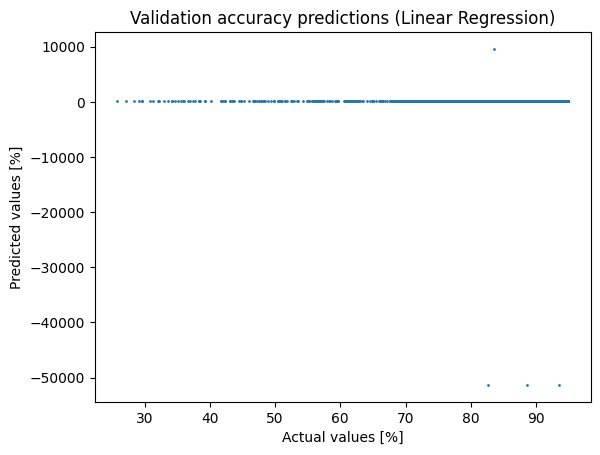

In [47]:
plt.scatter(targets_100k_scaled, lr_predictions_scaled, s=1)
plt.xlabel("Actual values [%]")
plt.ylabel("Predicted values [%]")
plt.title("Validation accuracy predictions (Linear Regression)")
plt.savefig("imgs/lr_train1600.pdf")
plt.show()

### Random forest predictor

In [49]:
rf_predictions = rf_predictor.predict(features_100k)
rf_predictions_scaled = rf_predictions * 100

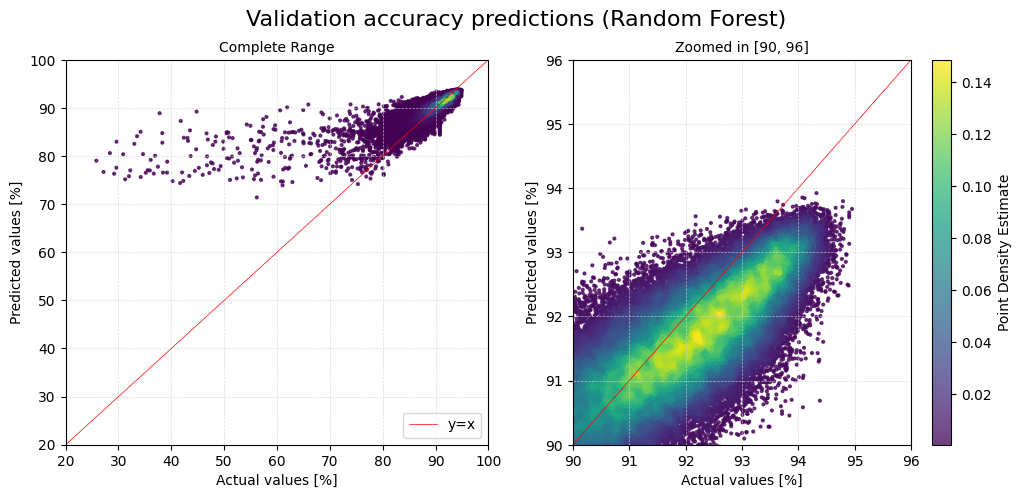

In [50]:

scatter_plot_nice(targets_100k_scaled, rf_predictions_scaled, "Validation accuracy predictions (Random Forest)", dense=True, save=True, filename="rf_train1600.pdf")

### XGBoost predictor

In [52]:
xgb_predictions = xgb_predictor.predict(features_100k)
xgb_predictions_scaled = xgb_predictions * 100

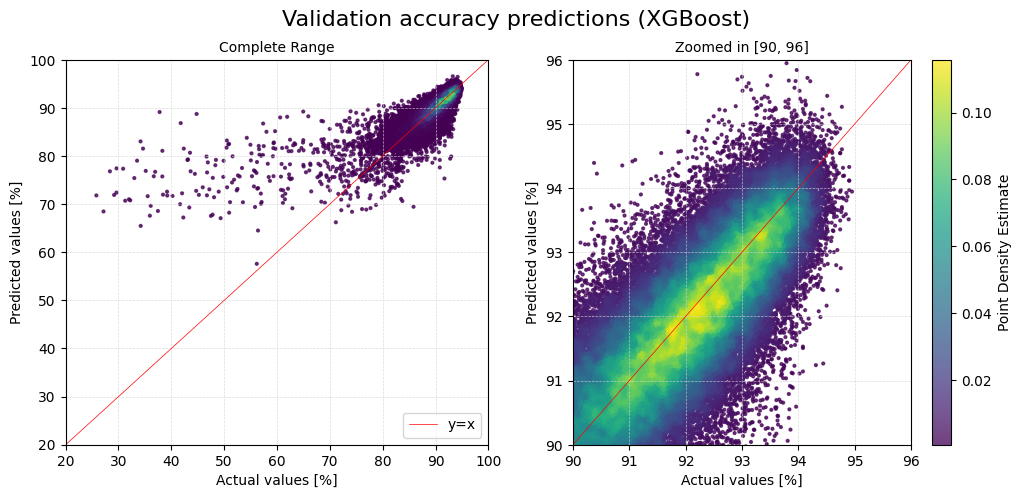

In [53]:

scatter_plot_nice(targets_100k_scaled, xgb_predictions_scaled, "Validation accuracy predictions (XGBoost)", dense=True, save=True, filename="xgb_train1600.pdf")

### MLP predictor

In [55]:
mlp_predictions = mlp_predictor.predict(features_100k)
mlp_predictions_scaled = mlp_predictions * 100

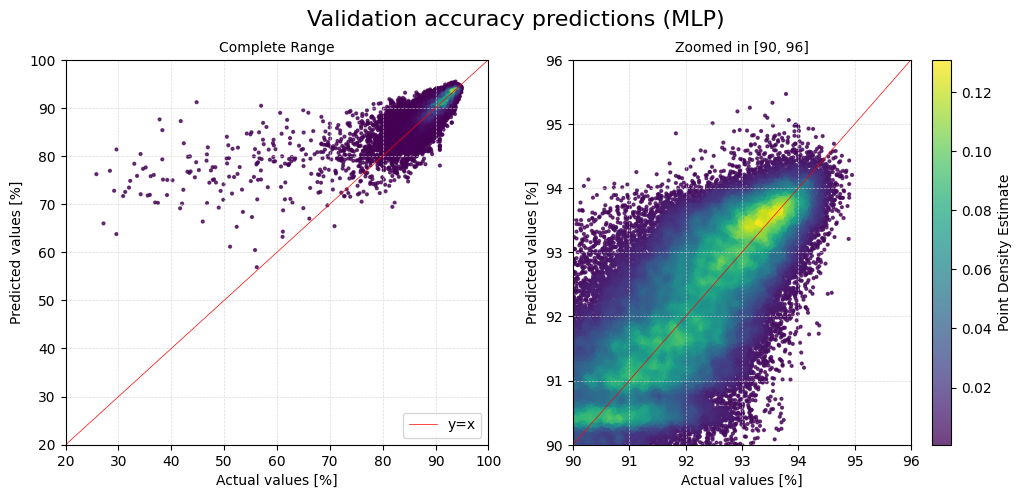

In [56]:
scatter_plot_nice(targets_100k_scaled, mlp_predictions_scaled, "Validation accuracy predictions (MLP)", dense=True, save=True, filename="mlp_train1600.pdf")

### GCN predictor

In [58]:
gcn_predictions = gcn_predictor.predict(features_gcn_100k)
gcn_predictions_scaled = gcn_predictions * 100 

[05/13 15:13:29] INFO (root) Batch 1, Loss: 1.4832, MSE: 14832.2712
[05/13 15:13:29] INFO (root) Batch 2, Loss: 1.4946, MSE: 14945.7389
[05/13 15:13:29] INFO (root) Batch 3, Loss: 1.5537, MSE: 15537.0689
[05/13 15:13:29] INFO (root) Batch 4, Loss: 1.5616, MSE: 15615.7819
[05/13 15:13:29] INFO (root) Batch 5, Loss: 1.6173, MSE: 16173.4625
[05/13 15:13:29] INFO (root) Batch 6, Loss: 1.6007, MSE: 16007.2357
[05/13 15:13:29] INFO (root) Batch 7, Loss: 1.5843, MSE: 15843.1748
[05/13 15:13:29] INFO (root) Batch 8, Loss: 1.5504, MSE: 15503.6367
[05/13 15:13:29] INFO (root) Batch 9, Loss: 1.5429, MSE: 15428.5265
[05/13 15:13:30] INFO (root) Batch 10, Loss: 1.5393, MSE: 15392.7693
[05/13 15:13:30] INFO (root) Batch 11, Loss: 1.5519, MSE: 15519.0610
[05/13 15:13:30] INFO (root) Batch 12, Loss: 1.5434, MSE: 15433.5044
[05/13 15:13:30] INFO (root) Batch 13, Loss: 1.5347, MSE: 15346.9384
[05/13 15:13:30] INFO (root) Batch 14, Loss: 1.5480, MSE: 15480.3432
[05/13 15:13:30] INFO (root) Batch 15, Loss

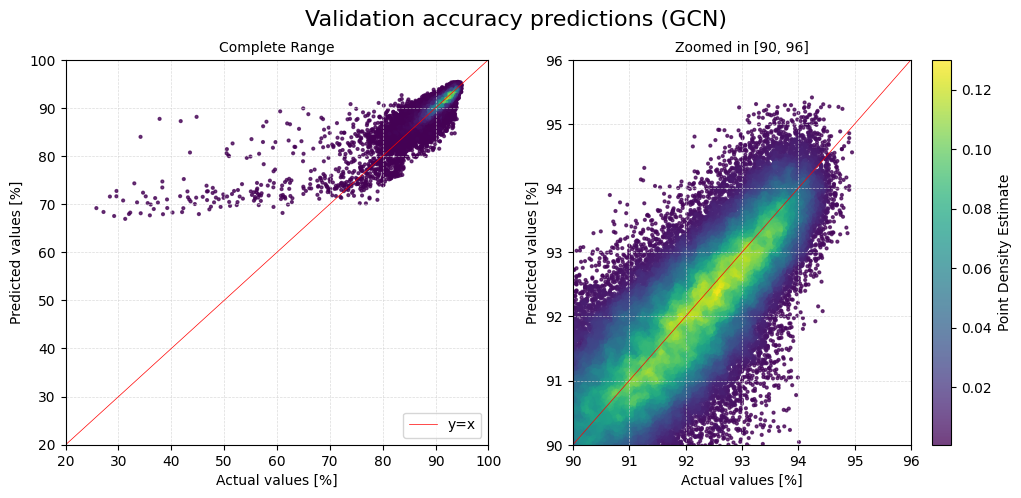

In [59]:

scatter_plot_nice(targets_100k_scaled, gcn_predictions_scaled, "Validation accuracy predictions (GCN)", dense=True, save=True, filename="gcn_train1600.pdf")